In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from torch.nn.init import kaiming_normal
from torch.distributions.categorical import Categorical

import tqdm

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
print("Is python : {}".format(is_ipython))

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

Is python : True
Device : cuda


In [3]:
class PGNet(nn.Module):
    # плейсхолдер для определения модели
    # не забудьте, что выход policy-gradients модели - вероятности действий
    
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        #x = F.relu(self.conv1(x))
        x = F.relu(self.bn2(self.conv2(x)))
        #x = F.relu(self.conv2(x))
        x = F.relu(self.bn3(self.conv3(x)))
        #x = F.relu(self.conv3(x))
        x = self.head(x.view(x.size(0), -1))
        return self.softmax(x)

### Вход


Вытаскиваем картинку из среды. Используем бонусы из ``torchvision``



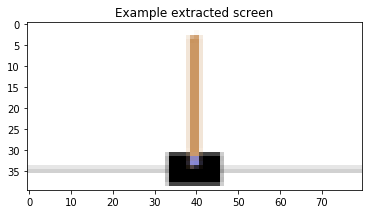

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # транспонирование в порядок торча (СHW)
    # Убираем верх и низ экрана
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Убираем края экрана, чтобы получить картинку с центрированной тележкой
    screen = screen[:, :, slice_range]
    # Конвертируем в торч тензор
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Ресайзим и добавляем батч размерность
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [ ]:
BATCH_SIZE = 5000
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE=10

policy_net = PGNet().to(device)

# можно попробовать
optimizer = optim.SGD(policy_net.parameters(), lr=0.001, momentum=0.9, nesterov=True)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        #print("Return by policy")
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        #print("Return random")
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
# метод для десконтирования reward'ов
def discount_rewards(rewards):
    R = 0
    
    for r in rewards[::-1]:
        R = r + GAMMA * R
    
    return(R)
    

### Тренировка модели


In [ ]:
# метод для оптимизации модели
def optimize_model(log_probas, rewards):
    pass

#### Тренируем модель


In [1]:
num_episodes = 500 # суммарное кол-во эпизодов
ep_per_epoch = 5 # кол-во эпизодов м/у обучением

log_probas = []
rewards = []

policy_net.train()
last_100_ep_duration = 0

for i_episode in tqdm.tqdm(range(num_episodes)):
    
    # Ура! Выйграли этот энвайронмент!
    if last_100_ep_duration >= 195:
        break
    
    # Инициализация среды
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
    
        # тут какая-то магия, при которой мы получаем вер-ти очередного действия
        
        
        # Выбрать и выполнить новое действие
        pass

        # Получаем новое состояние
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Переходим в новое состояние
        state = next_state
            
        if done:
            # Оптимайзимся
            if (i_episode + 1) % ep_per_epoch == 0:
                optimize_model(log_probas, rewards)

            episode_durations.append(t + 1)
            last_100_ep_durations = np.mean(episode_durations[-100:])
            print("Mean last 100 ep durations : {}".format(last_100_ep_durations))
            plot_durations()
            break
            
print('Complete')
env.render()
env.close()
#plt.ioff()
plt.show()

NameError: name 'policy_net' is not defined

In [ ]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
#print(type(state))
total_reward = 0

policy_net.eval()

for i in range(1000):
    # Выбрать и выполнить нове действие
    m = Categorical(policy_net.forward(state))
    action = m.sample()
    _,reward,done,_ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None
        break
    state = next_state
    show_state(env, i)
print(f"Total reward = {total_reward}")